In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from __future__ import print_function

### Test with toy model

In [2]:
topology = paths.engines.toy.Topology(n_spatial=3, 
                                      n_atoms=2, 
                                      masses=np.array([2.0, 8.0]), 
                                      pes=None)
initial_snapshot = paths.engines.toy.Snapshot(
    coordinates=np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]),
    velocities=np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]),
    engine=paths.engines.toy.Engine({}, topology)
)

We'll define the modifier at two different temperatures, and we'll run each for 10000 snapshots. Note also that our two atoms have different masses.

In [3]:
modifier_1 = paths.RandomVelocities(beta=1.0)
modifier_5 = paths.RandomVelocities(beta=1.0/5.0)

In [4]:
snapshots_1 = [modifier_1(initial_snapshot) for i in range(10000)]
snapshots_5 = [modifier_5(initial_snapshot) for i in range(10000)]

Within each atom, all 3 DOFs will be part of the same distribution. We create a few lists with names of the form `v_${BETA}_${ATOM_NUMBER}`. These are the results we'll histogram and test.

In [5]:
v_1_0 = sum([s.velocities[0].tolist() for s in snapshots_1], [])
v_1_1 = sum([s.velocities[1].tolist() for s in snapshots_1], [])
v_5_0 = sum([s.velocities[0].tolist() for s in snapshots_5], [])
v_5_1 = sum([s.velocities[1].tolist() for s in snapshots_5], [])

We know what the distribution should look like, so we write it down explicitly:

In [6]:
def expected(beta, mass, v):
    alpha = 0.5*beta*mass
    return np.sqrt(alpha/np.pi)*np.exp(-alpha*v**2)

Now we take each total distribution, and compare it to the expected distribution. This is where we have to use our eyes to check the correctness.

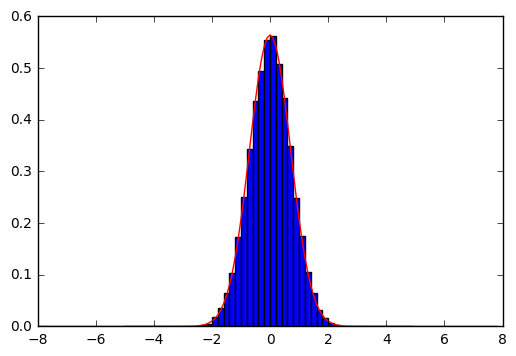

In [7]:
v = np.arange(-5.0, 5.0, 0.1)
bins = np.arange(-8.0, 8.0, 0.2)
plt.hist(v_1_0, bins=bins, normed=True)
plt.plot(v, expected(1.0, 2.0, v), 'r');

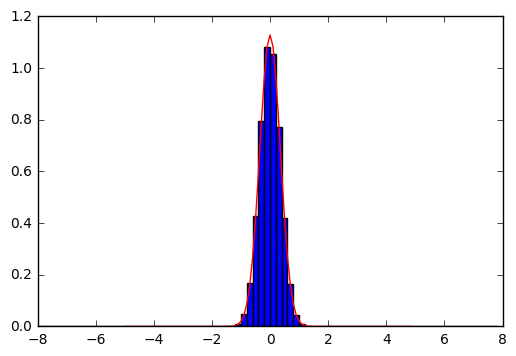

In [8]:
v = np.arange(-5.0, 5.0, 0.1)
bins = np.arange(-8.0, 8.0, 0.2)
plt.hist(v_1_1, bins=bins, normed=True)
plt.plot(v, expected(1.0, 8.0, v), 'r');

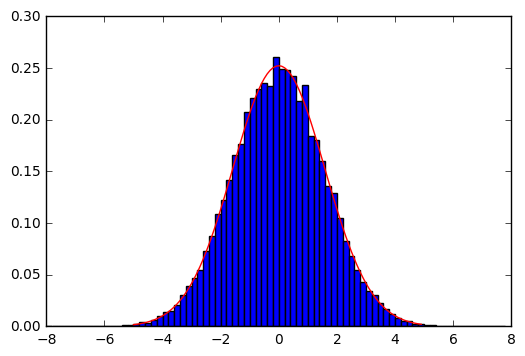

In [9]:
v = np.arange(-5.0, 5.0, 0.1)
bins = np.arange(-8.0, 8.0, 0.2)
plt.hist(v_5_0, bins=bins, normed=True)
plt.plot(v, expected(0.2, 2.0, v), 'r');

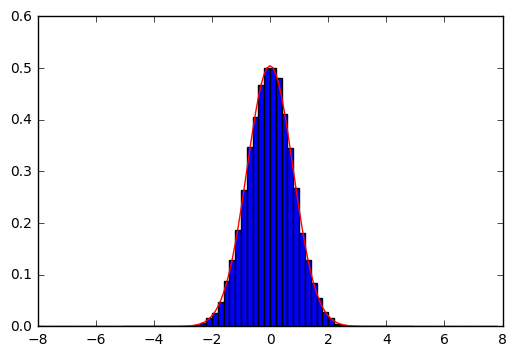

In [10]:
v = np.arange(-5.0, 5.0, 0.1)
bins = np.arange(-8.0, 8.0, 0.2)
plt.hist(v_5_1, bins=bins, normed=True)
plt.plot(v, expected(0.2, 8.0, v), 'r');

If the red lines match the blue histograms, we're good. Otherwise, something has gone terribly wrong.

### Test with OpenMM

In [11]:
import openmmtools as omt
import openpathsampling.engines.openmm as omm_engine
import simtk.unit as u
test_system = omt.testsystems.AlanineDipeptideVacuum()
template = omm_engine.snapshot_from_testsystem(test_system)

In [12]:
# just to show that the initial velocities are all 0
template.velocities

Quantity(value=array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]]), unit=nanometer/picosecond)

In [13]:
temperature = 300.0 * u.kelvin
beta = 1.0 / (temperature * u.BOLTZMANN_CONSTANT_kB)

In [14]:
full_randomizer = paths.RandomVelocities(beta)
fully_randomized_snapshot = full_randomizer(template)
fully_randomized_snapshot.velocities

Quantity(value=array([[-0.52844825,  0.08770043, -1.14353565],
       [-0.16655209, -0.01401895,  0.27391035],
       [-0.91627403, -0.08102603, -1.73734039],
       [ 0.23619285,  3.09318031,  0.29210081],
       [-0.55862811,  0.03286213, -0.17449808],
       [-0.29364157,  0.01655207,  0.342345  ],
       [-0.0388821 , -0.38440991,  0.17714685],
       [ 2.46263005,  1.99191358, -1.60551321],
       [-0.26459683, -0.0497971 ,  0.5542096 ],
       [ 0.2418242 ,  2.23233597, -0.67517488],
       [ 0.37587967, -0.36600417,  0.57353365],
       [ 0.05933524, -0.79933227,  0.32132531],
       [ 0.61924392, -0.66111475, -0.40589899],
       [-1.50730745,  2.12090656, -1.3615101 ],
       [-0.4552141 ,  0.70384761, -0.11358002],
       [ 0.54071607,  0.34659863,  0.10625407],
       [-0.34157622, -0.35270671, -0.00650735],
       [-2.63767853,  2.69596688, -0.64955249],
       [ 0.14817487,  0.13794325,  0.33554463],
       [-0.35634762,  0.57028156, -0.28479863],
       [-0.13133321,  1.6

That version randomized all velcoties; we can also create a `SnapshotModifier` that only modifies certain velocities. For example, we might be interested in modifying the velocities of a solvent while ignoring the solute.

Next we create a little example that only modifies the velocities of the carbon atoms in alanine dipeptide.

In [15]:
carbon_atoms = template.topology.mdtraj.select("element C")
carbon_randomizer = paths.RandomVelocities(beta, subset_mask=carbon_atoms)
carbon_randomized_snapshot = carbon_randomizer(template)
carbon_randomized_snapshot.velocities

Quantity(value=array([[ 0.        ,  0.        ,  0.        ],
       [-0.12101624, -0.61911357,  0.37004857],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.17451611, -0.36194396,  0.03017651],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.54968347,  0.0976371 , -0.43616674],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.49871899, -0.72371682, -0.74019351],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.00781357,  0.76133461,  0.0580251 ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.05368577,  0.34271538, -0.56028227],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0. 

Note that only the 6 carbon atoms, selected by the `subset_mask`, have changed velocities from the template's value of `0.0`.

Finally, we'll check that the OpenMM version is giving the right statistics:

In [16]:
carbon_velocities = [carbon_randomizer(template).velocities[carbon_atoms] for i in range(1000)]

In [17]:
all_dof_values = sum(np.concatenate(carbon_velocities).tolist(), [])
print(len(all_dof_values))

18000


In [18]:
dalton_mass = 12.0
# manually doing conversions here
carbon_mass = dalton_mass / (6.02*10**23) * 10**-3 # kg
boltzmann = 1.38 * 10**-23 # J/K
m_s__to__nm_ps = 10**-3

temperature = 300.0 # K

kB_T = boltzmann * temperature * m_s__to__nm_ps**2

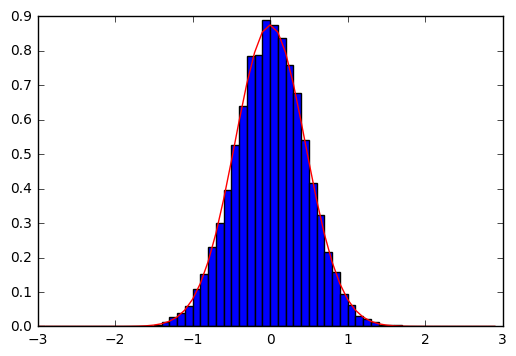

In [19]:
v = np.arange(-3.0, 3.0, 0.1)
bins = np.arange(-3.0, 3.0, 0.1)
plt.hist(all_dof_values, bins=bins, normed=True);
plt.plot(v, expected(1.0/kB_T, carbon_mass, v), 'r')